In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")

#### 1. Load Data

In [3]:
# Load original datasets
customers = pd.read_csv('../datasets/olist_customers_dataset.csv')
order_items = pd.read_csv('../datasets/olist_order_items_dataset.csv')
sellers = pd.read_csv('../datasets/olist_sellers_dataset.csv')
payments = pd.read_csv('../datasets/olist_order_payments_dataset.csv')
category_translation = pd.read_csv('../datasets/product_category_name_translation.csv')    
# Load cleaned datasets
orders = pd.read_csv('../datasets/orders_clean.csv')
products = pd.read_csv('../datasets/products_clean.csv')
reviews = pd.read_csv('../datasets/reviews_clean.csv')
geo_location = pd.read_csv('../datasets/geolocation_clean.csv')

#### Sales Trend Over Time with Moving Average

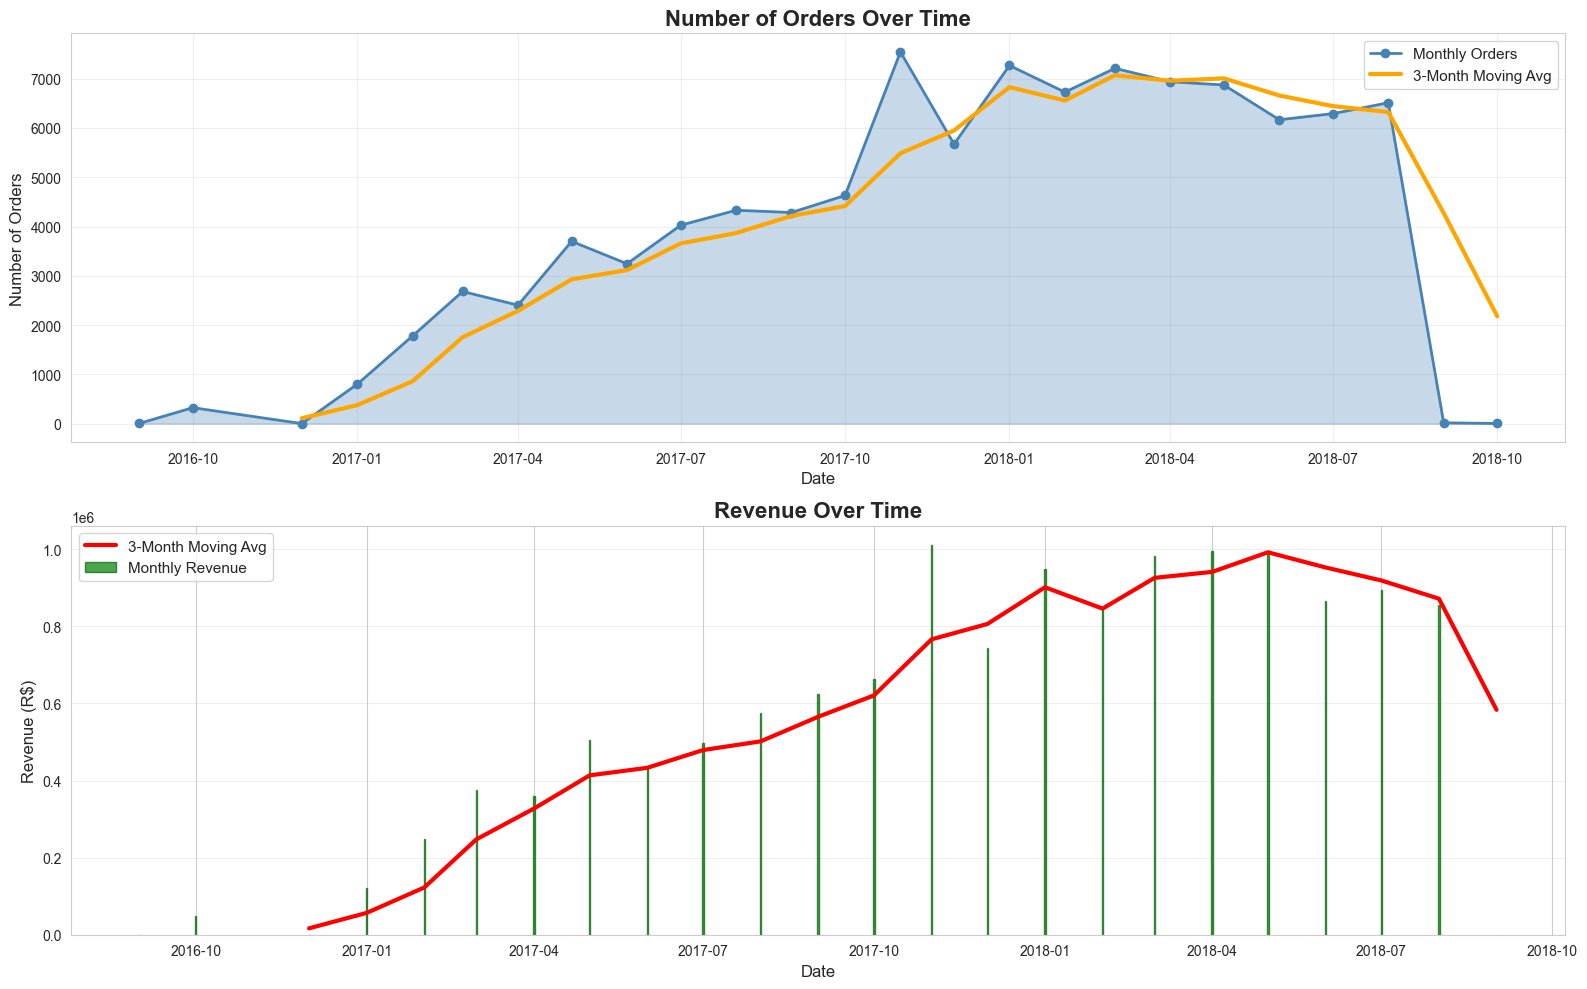

In [9]:
# Convert date columns to datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 
                'order_delivered_carrier_date', 'order_delivered_customer_date',
                'order_estimated_delivery_date']
for col in date_columns:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Monthly orders
orders['year_month'] = orders['order_purchase_timestamp'].dt.to_period('M')
monthly_orders = orders.groupby('year_month').size()
monthly_orders.index = monthly_orders.index.to_timestamp()

# Calculate revenue per month
order_revenue = order_items.merge(orders[['order_id', 'year_month']], on='order_id')
monthly_revenue = order_revenue.groupby('year_month')['price'].sum()
monthly_revenue.index = monthly_revenue.index.to_timestamp()

# Plot 1: Orders
axes[0].plot(monthly_orders.index, monthly_orders.values, marker='o', linewidth=2, 
             markersize=6, color='steelblue', label='Monthly Orders')
axes[0].plot(monthly_orders.index, monthly_orders.rolling(3).mean().values, 
             linewidth=3, color='orange', label='3-Month Moving Avg')
axes[0].fill_between(monthly_orders.index, monthly_orders.values, alpha=0.3, color='steelblue')
axes[0].set_title('Number of Orders Over Time', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Orders', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Revenue
axes[1].bar(monthly_revenue.index, monthly_revenue.values, color='green', alpha=0.7, 
            edgecolor='darkgreen', label='Monthly Revenue')
axes[1].plot(monthly_revenue.index, monthly_revenue.rolling(3).mean().values, 
             linewidth=3, color='red', label='3-Month Moving Avg')
axes[1].set_title('Revenue Over Time', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Revenue (R$)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('viz_sales_trend.png', dpi=300, bbox_inches='tight')
plt.show()

#### Product Categories with Revenue & Cost

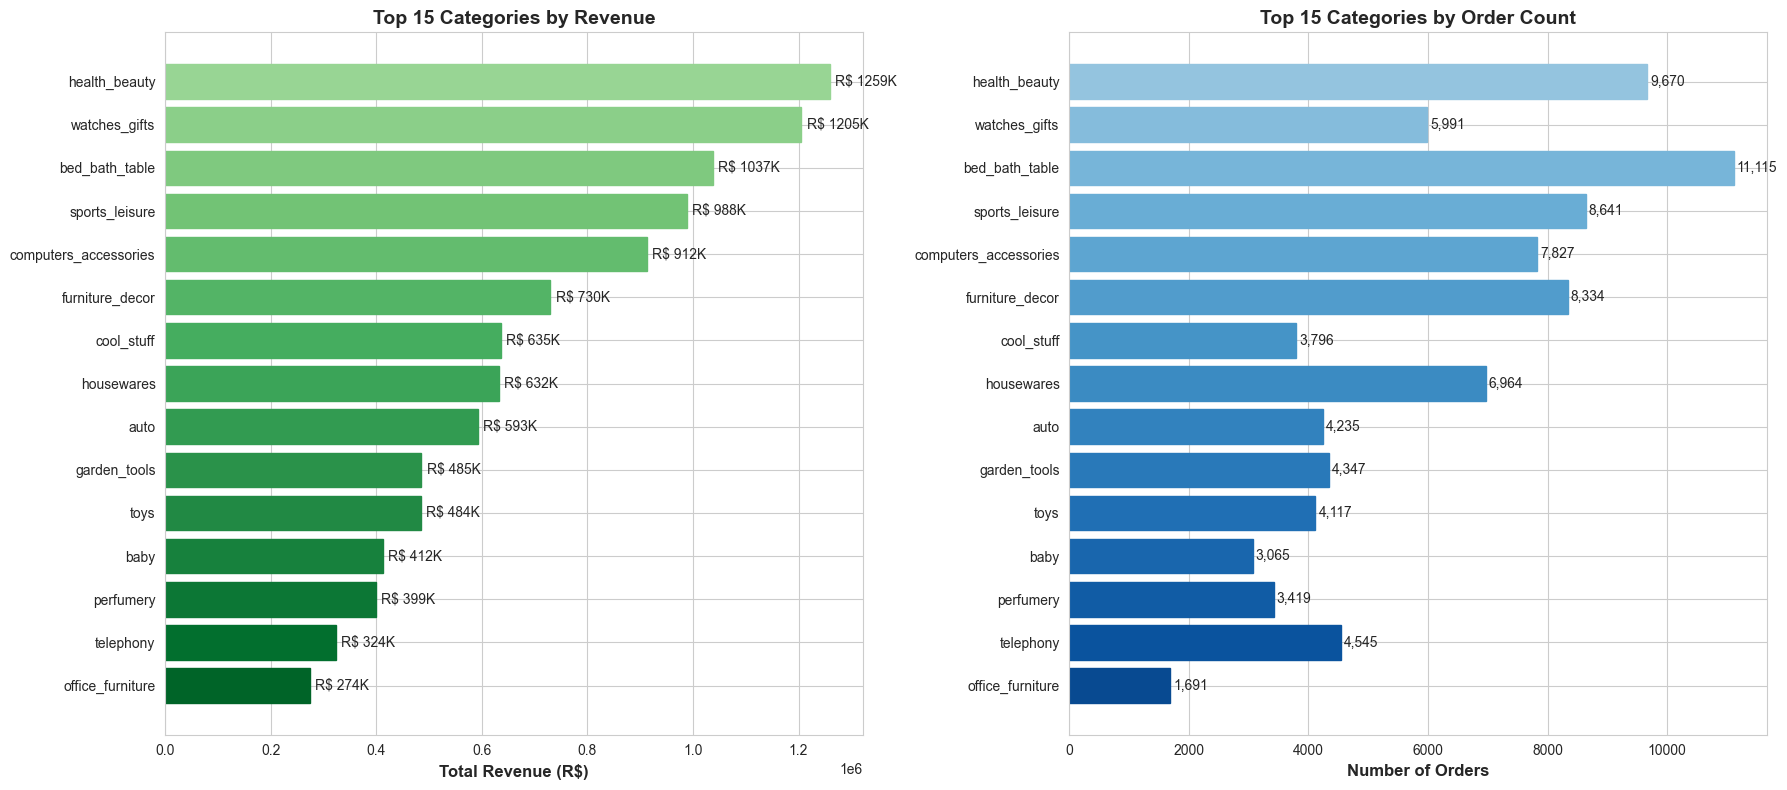

In [5]:
products_translated = products.merge(category_translation, on='product_category_name', how='left')
order_items_products = order_items.merge(products_translated, on='product_id', how='left')

# Get top categories by count and revenue
category_stats = order_items_products.groupby('product_category_name_english').agg({
    'order_id': 'count',
    'price': 'sum'
}).rename(columns={'order_id': 'count', 'price': 'revenue'})
category_stats = category_stats.sort_values('revenue', ascending=False).head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Revenue
bars1 = axes[0].barh(range(len(category_stats)), category_stats['revenue'].values)
colors1 = plt.cm.Greens(np.linspace(0.4, 0.9, len(category_stats)))
for bar, color in zip(bars1, colors1):
    bar.set_color(color)

axes[0].set_yticks(range(len(category_stats)))
axes[0].set_yticklabels(category_stats.index)
axes[0].set_xlabel('Total Revenue (R$)', fontsize=12, fontweight='bold')
axes[0].set_title('Top 15 Categories by Revenue', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

for i, v in enumerate(category_stats['revenue'].values):
    axes[0].text(v + 10000, i, f'R$ {v/1000:.0f}K', va='center', fontsize=10)

# Order count
bars2 = axes[1].barh(range(len(category_stats)), category_stats['count'].values)
colors2 = plt.cm.Blues(np.linspace(0.4, 0.9, len(category_stats)))
for bar, color in zip(bars2, colors2):
    bar.set_color(color)

axes[1].set_yticks(range(len(category_stats)))
axes[1].set_yticklabels(category_stats.index)
axes[1].set_xlabel('Number of Orders', fontsize=12, fontweight='bold')
axes[1].set_title('Top 15 Categories by Order Count', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

for i, v in enumerate(category_stats['count'].values):
    axes[1].text(v + 50, i, f'{v:,}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('viz_top_categories.png', dpi=300, bbox_inches='tight')
plt.show()


#### Geographic heatmap - Customer & Seller distribution

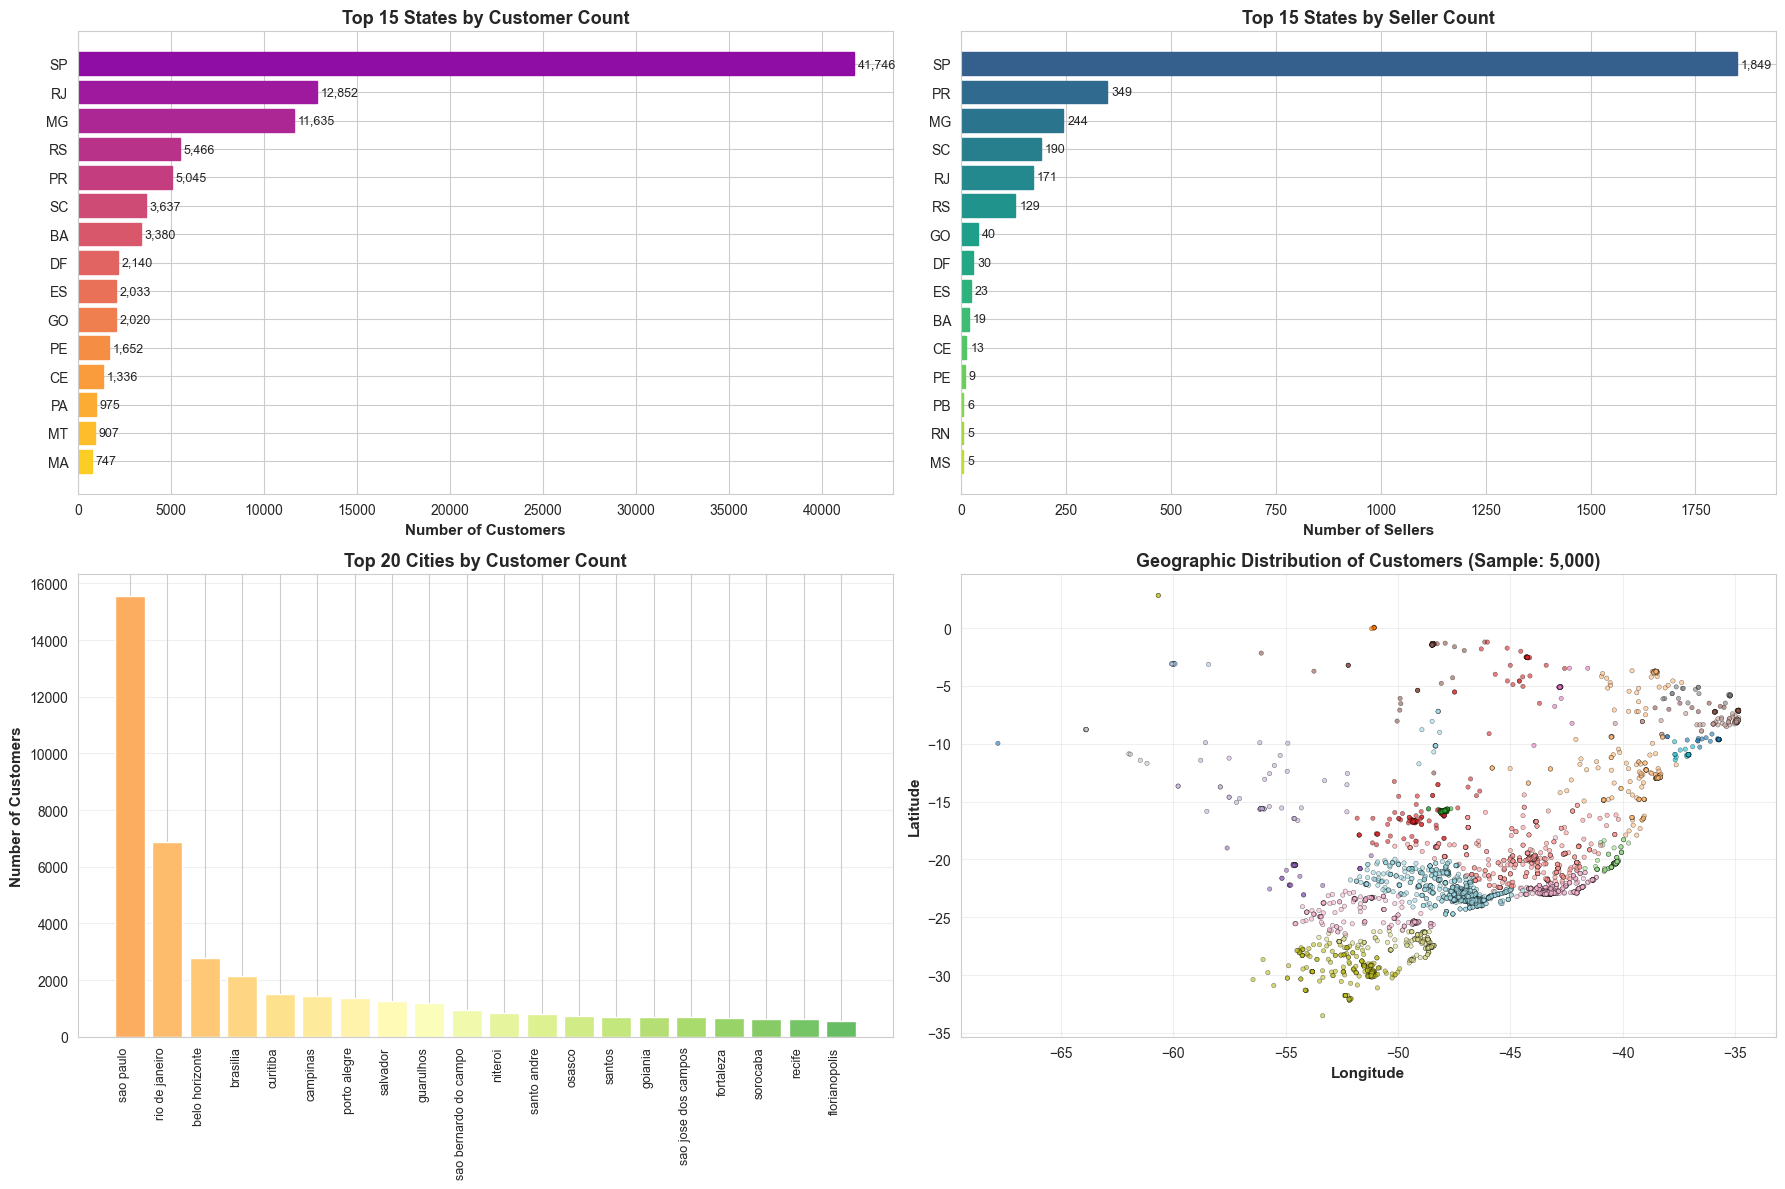

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Customer states
customer_states = customers['customer_state'].value_counts().head(15)
bars = axes[0, 0].barh(range(len(customer_states)), customer_states.values)
colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(customer_states)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

axes[0, 0].set_yticks(range(len(customer_states)))
axes[0, 0].set_yticklabels(customer_states.index)
axes[0, 0].set_xlabel('Number of Customers', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Top 15 States by Customer Count', fontsize=13, fontweight='bold')
axes[0, 0].invert_yaxis()

for i, v in enumerate(customer_states.values):
    axes[0, 0].text(v + 200, i, f'{v:,}', va='center', fontsize=9)

# Seller states
seller_states = sellers['seller_state'].value_counts().head(15)
bars = axes[0, 1].barh(range(len(seller_states)), seller_states.values)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(seller_states)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

axes[0, 1].set_yticks(range(len(seller_states)))
axes[0, 1].set_yticklabels(seller_states.index)
axes[0, 1].set_xlabel('Number of Sellers', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Top 15 States by Seller Count', fontsize=13, fontweight='bold')
axes[0, 1].invert_yaxis()

for i, v in enumerate(seller_states.values):
    axes[0, 1].text(v + 10, i, f'{v:,}', va='center', fontsize=9)

# Customer cities (top 20)
customer_cities = customers['customer_city'].value_counts().head(20)
axes[1, 0].bar(range(len(customer_cities)), customer_cities.values, 
               color=plt.cm.RdYlGn(np.linspace(0.3, 0.8, len(customer_cities))))
axes[1, 0].set_xticks(range(len(customer_cities)))
axes[1, 0].set_xticklabels(customer_cities.index, rotation=90, ha='right', fontsize=9)
axes[1, 0].set_ylabel('Number of Customers', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Top 20 Cities by Customer Count', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Geographic scatter (using geolocation)
# Sample customers with coordinates
customers_geo = customers.merge(
    geo_location,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='inner'
)

# Sample for performance
sample_size = min(5000, len(customers_geo))
customers_sample = customers_geo.sample(n=sample_size, random_state=42)

scatter = axes[1, 1].scatter(
    customers_sample['geolocation_lng'],
    customers_sample['geolocation_lat'],
    c=customers_sample['customer_state'].astype('category').cat.codes,
    cmap='tab20',
    alpha=0.6,
    s=10,
    edgecolors='black',
    linewidth=0.3
)
axes[1, 1].set_xlabel('Longitude', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Latitude', fontsize=11, fontweight='bold')
axes[1, 1].set_title(f'Geographic Distribution of Customers (Sample: {sample_size:,})', 
                     fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('viz_geographic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

#### Payment Analysis - methods, installments, values

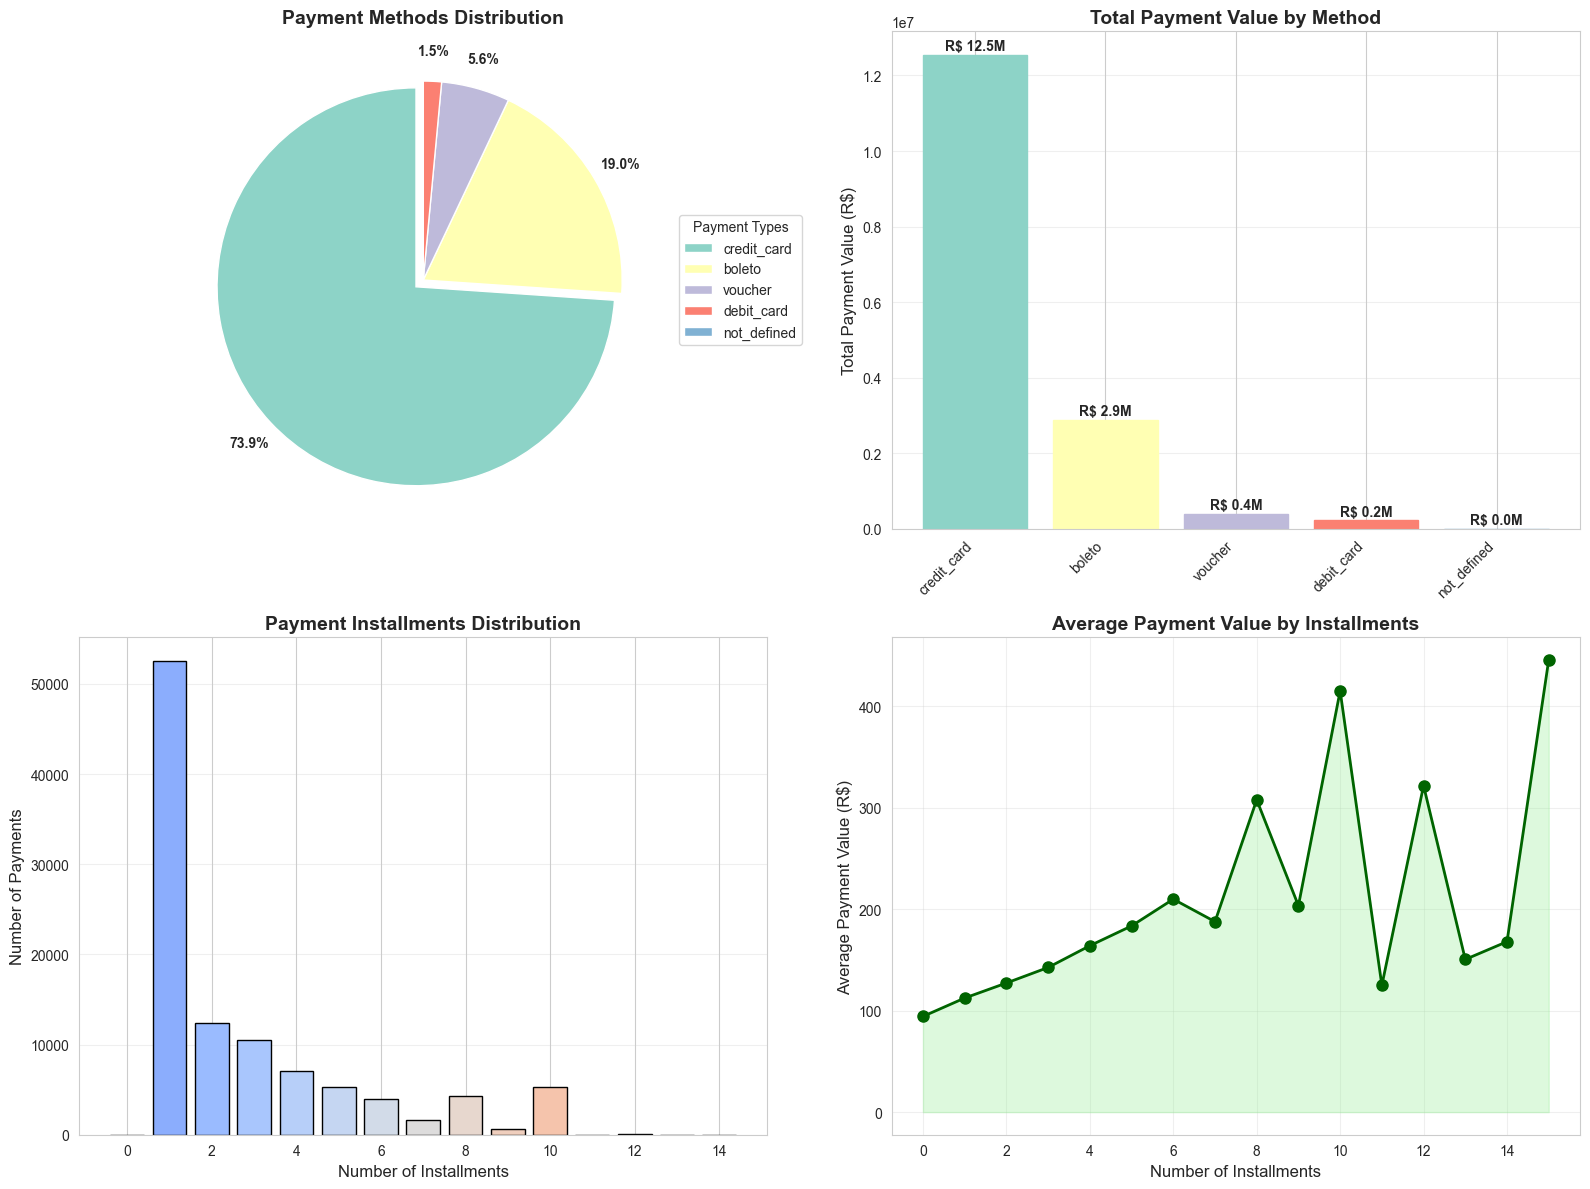

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Payment type distribution
payment_counts = payments['payment_type'].value_counts()
colors_pie = plt.cm.Set3(range(len(payment_counts)))

def filter_autopct(pct):
    return '%1.1f%%' % pct if pct > 0.1 else ''

# Create the pie chart without labels on the wedges
wedges, texts, autotexts = axes[0, 0].pie(
    payment_counts.values, 
    labels=None, 
   autopct=filter_autopct,
    startangle=90, 
    colors=colors_pie, 
    pctdistance=1.15,  # Value > 1 moves text outside the circle
    explode=[0.05 if i == 0 else 0 for i in range(len(payment_counts))]
)

# Style the percentage text
for autotext in autotexts:   
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# Add a legend to the side
axes[0, 0].legend(
    wedges, 
    payment_counts.index, 
    title="Payment Types",
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1) # Coordinates to move legend outside
)

axes[0, 0].set_title('Payment Methods Distribution', fontsize=14, fontweight='bold')

# Payment value by type
payment_values = payments.groupby('payment_type')['payment_value'].sum().sort_values(ascending=False)
bars = axes[0, 1].bar(range(len(payment_values)), payment_values.values)

for bar, color in zip(bars, colors_pie):
    bar.set_color(color)

axes[0, 1].set_xticks(range(len(payment_values)))
axes[0, 1].set_xticklabels(payment_values.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Total Payment Value (R$)', fontsize=12)
axes[0, 1].set_title('Total Payment Value by Method', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(payment_values.values):
    axes[0, 1].text(i, v + 50000, f'R$ {v/1e6:.1f}M', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')

# Installments distribution
installment_dist = payments['payment_installments'].value_counts().sort_index().head(15)
axes[1, 0].bar(installment_dist.index, installment_dist.values, 
               color=plt.cm.coolwarm(np.linspace(0.2, 0.8, len(installment_dist))),
               edgecolor='black')
axes[1, 0].set_xlabel('Number of Installments', fontsize=12)
axes[1, 0].set_ylabel('Number of Payments', fontsize=12)
axes[1, 0].set_title('Payment Installments Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Average payment value by installments
avg_by_installments = payments.groupby('payment_installments')['payment_value'].mean()
avg_by_installments = avg_by_installments[avg_by_installments.index <= 15]

axes[1, 1].plot(avg_by_installments.index, avg_by_installments.values, 
                marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1, 1].fill_between(avg_by_installments.index, avg_by_installments.values, 
                        alpha=0.3, color='lightgreen')
axes[1, 1].set_xlabel('Number of Installments', fontsize=12)
axes[1, 1].set_ylabel('Average Payment Value (R$)', fontsize=12)
axes[1, 1].set_title('Average Payment Value by Installments', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('viz_payment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


#### Delivery Performance Analysis 

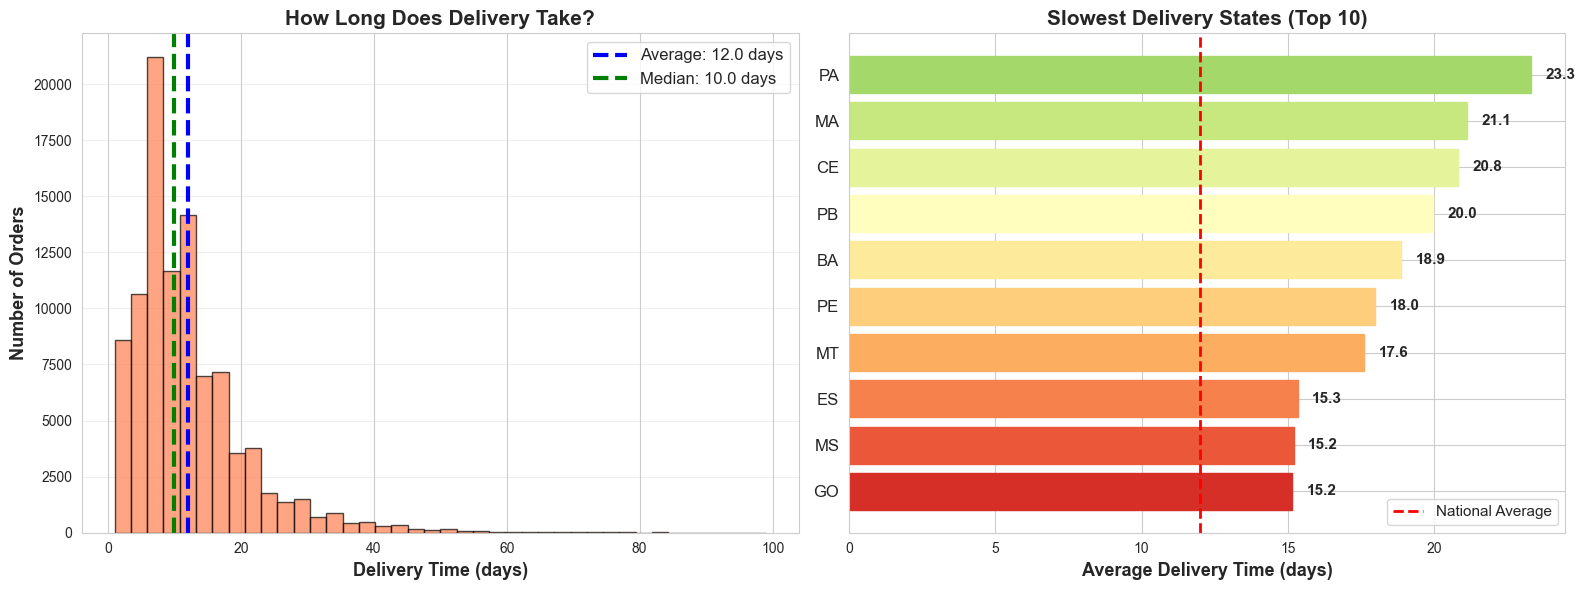

In [8]:
orders['delivery_time_days'] = pd.to_numeric(orders['delivery_time_days'], errors='coerce')
valid_delivery = orders[(orders['delivery_time_days'] > 0) & 
                        (orders['delivery_time_days'] < 100)].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Simple delivery time distribution
axes[0].hist(valid_delivery['delivery_time_days'], bins=40, 
            edgecolor='black', alpha=0.7, color='coral')
axes[0].axvline(valid_delivery['delivery_time_days'].mean(), color='blue', 
               linestyle='--', linewidth=3, 
               label=f'Average: {valid_delivery["delivery_time_days"].mean():.1f} days')
axes[0].axvline(valid_delivery['delivery_time_days'].median(), color='green', 
               linestyle='--', linewidth=3, 
               label=f'Median: {valid_delivery["delivery_time_days"].median():.1f} days')
axes[0].set_xlabel('Delivery Time (days)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Orders', fontsize=13, fontweight='bold')
axes[0].set_title('How Long Does Delivery Take?', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Top states by delivery time
customers_orders = orders.merge(customers[['customer_id', 'customer_state']], on='customer_id')
state_delivery = customers_orders.groupby('customer_state')['delivery_time_days'].agg(['mean', 'count'])
state_delivery = state_delivery[state_delivery['count'] > 500].sort_values('mean', ascending=False).head(10)

bars = axes[1].barh(range(len(state_delivery)), state_delivery['mean'].values)
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(state_delivery)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

axes[1].set_yticks(range(len(state_delivery)))
axes[1].set_yticklabels(state_delivery.index, fontsize=12)
axes[1].set_xlabel('Average Delivery Time (days)', fontsize=13, fontweight='bold')
axes[1].set_title('Slowest Delivery States (Top 10)', fontsize=15, fontweight='bold')
axes[1].invert_yaxis()
axes[1].axvline(x=valid_delivery['delivery_time_days'].mean(), 
               color='red', linestyle='--', linewidth=2, label='National Average')
axes[1].legend(fontsize=11)

for i, v in enumerate(state_delivery['mean'].values):
    axes[1].text(v + 0.5, i, f'{v:.1f}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('viz_delivery_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
